Handling non stationary data.
$$ARIMA(p, d, q)$$ 
- $p$ : $AR$ order
- $d$ : $MA$ order
- $q$ : Integrity order. The number of times we need to integrate the time-series to ensure stationarity.

Accounting for the non-seasonal difference between periods.
$$Δ^{d}P_t=c+\sum_{i=1}^{p}\phi_tΔ^{d}P_{t-i}+\sum_{i=1}^{q}\theta_t\epsilon_{t-i}+\epsilon_t$$
- $P_t$ : Values in the current period
- $\epsilon_t$ : Error terms in the current period
- $c$ Baseline constant factor
- $\phi_t$ : What part of the value in the period ${t-1}$ is relevant in explaining the current one
- $\theta_t$ : What part of the error in the period ${t-1}$ is relevant in explaining the current value
- $ΔP_t=P_t-P_{t-1}$

* $ARIMA$ doesn't have functions like $ACF$ and $PACF$. We'll examine the $ACF$ of the $\epsilon_t$
* For any integration, we lose a single observation.
* We can lose one or more observations. We exactely lose $d$ observations, where $d$ is the order of the integration. 

## Importing packages

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from math  import sqrt
import seaborn as sns
from google.colab import drive
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")
sns.set()

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


## Importing the Data and Pre-Processing

In [55]:
raw_csv_data = pd.read_csv("/content/drive/MyDrive/Formations/Time Series/Index2018.csv", index_col="date", parse_dates=True, dayfirst=True)
df_comp = raw_csv_data.copy()
df_comp = df_comp.asfreq("b")
df_comp = df_comp.fillna(method="ffill")
df_comp["market_value"] = df_comp.ftse

size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp[size:]

## LLR Test

In [4]:
"""mod_1, mod_2 : models we want to compare
DF : degrees of freedom"""
def LLR_test(mod_1, mod_2, DF=1):
  L1 = mod_1.fit().llf 
  L2 = mod_2.fit().llf
  LR = 2*(L2-L1) 
  p = chi2.sf(LR, DF).round(3)
  return p 

## Creating Returns

In [5]:
df["returns"] = df.market_value.pct_change(1)*100

## ARIMA(1, 1, 1)
* We notice that there is not constant because when we integrate, the constant of $P_{t-1}$ will be subtracted from $P_t$. 

In [7]:
model_ar_1_i_1_ma_1 = ARIMA(df.market_value, order = (1, 1, 1))
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()
print(results_ar_1_i_1_ma_1.summary())

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27604.005
Date:                Tue, 28 Mar 2023   AIC                          55214.010
Time:                        22:01:10   BIC                          55233.574
Sample:                    01-07-1994   HQIC                         55220.866
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7459      0.059     12.653      0.000       0.630       0.861
ma.L1         -0.7919      0.053    -14.924      0.000      -0.896      -0.688
sigma2      3498.7750     40.933     85.476      0.0

## Residuals of the ARIMA(1, 1, 1)
* The coefficient for the 3-rd and 4-th lags are significantly different from $0$. This suggests that incorporating these lags into our model might signidicantly improve performance.

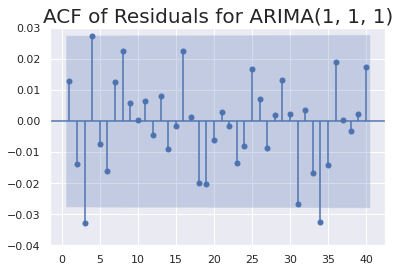

In [15]:
df['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid
sgt.plot_acf(df.res_ar_1_i_1_ma_1, zero = False, lags = 40)
plt.title("ACF of Residuals for ARIMA(1, 1, 1)", size = 20)
plt.ylim(-0.04, 0.03)
plt.show()

## Higher-Lag ARIMA Models
* Try $[ARIMA(1, 1, 1);ARIMA(4, 1, 4)]$

In [16]:
model_ar_1_i_1_ma_2 = ARIMA(df.market_value, order = (1, 1, 2))
results_ar_1_i_1_ma_2 = model_ar_1_i_1_ma_2.fit()

model_ar_1_i_1_ma_3 = ARIMA(df.market_value, order = (1, 1, 3))
results_ar_1_i_1_ma_3 = model_ar_1_i_1_ma_3.fit()

model_ar_2_i_1_ma_1 = ARIMA(df.market_value, order = (2, 1, 1))
results_ar_2_i_1_ma_1 = model_ar_2_i_1_ma_1.fit()

model_ar_3_i_1_ma_1 = ARIMA(df.market_value, order = (3, 1, 1))
results_ar_3_i_1_ma_1 = model_ar_3_i_1_ma_1.fit()

model_ar_3_i_1_ma_2 = ARIMA(df.market_value, order = (3, 1, 2))
results_ar_3_i_1_ma_2 = model_ar_3_i_1_ma_2.fit()

* $ARIMA(1, 1, 3)$ immediately becomes the front-runner of our shortlist.
* We have two nested models which are $ARIMA(1, 1, 2)$ and $ARIMA(1, 1, 1)$, so we should run LLR-test.

In [20]:
print("ARIMA(1, 1, 1): \tLL = ", results_ar_1_i_1_ma_1.llf, "\tAIC = ", results_ar_1_i_1_ma_1.aic)
print("ARIMA(1, 1, 2): \tLL = ", results_ar_1_i_1_ma_2.llf, "\tAIC = ", results_ar_1_i_1_ma_2.aic)
print("ARIMA(1, 1, 3): \tLL = ", results_ar_1_i_1_ma_3.llf, "\tAIC = ", results_ar_1_i_1_ma_3.aic)
print("ARIMA(2, 1, 1): \tLL = ", results_ar_2_i_1_ma_1.llf, "\tAIC = ", results_ar_2_i_1_ma_1.aic)
print("ARIMA(3, 1, 1): \tLL = ", results_ar_3_i_1_ma_1.llf, "\tAIC = ", results_ar_3_i_1_ma_1.aic)
print("ARIMA(3, 1, 2): \tLL = ", results_ar_3_i_1_ma_2.llf, "\tAIC = ", results_ar_3_i_1_ma_2.aic)


ARIMA(1, 1, 1): 	LL =  -27604.00511572735 	AIC =  55214.0102314547
ARIMA(1, 1, 2): 	LL =  -27600.40763254081 	AIC =  55208.81526508162
ARIMA(1, 1, 3): 	LL =  -27590.723481950256 	AIC =  55191.44696390051
ARIMA(2, 1, 1): 	LL =  -27600.130551053444 	AIC =  55208.26110210689
ARIMA(3, 1, 1): 	LL =  -27592.336116473074 	AIC =  55194.67223294615
ARIMA(3, 1, 2): 	LL =  -27590.920318056138 	AIC =  55193.840636112276


In [21]:
print(f"LLR test p-value {LLR_test(model_ar_1_i_1_ma_2, model_ar_1_i_1_ma_3)}")

LLR test p-value 0.0


In [22]:
print(f"LLR test p-value {LLR_test(model_ar_1_i_1_ma_1, model_ar_1_i_1_ma_3, DF=2)}")

LLR test p-value 0.0


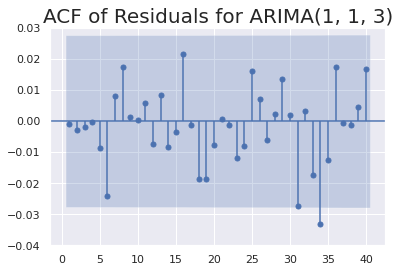

In [23]:
df['res_ar_1_i_1_ma_3'] = results_ar_1_i_1_ma_3.resid
sgt.plot_acf(df.res_ar_1_i_1_ma_3, zero = False, lags = 40)
plt.title("ACF of Residuals for ARIMA(1, 1, 3)", size = 20)
plt.ylim(-0.04, 0.03)
plt.show()

In [25]:
model_ar_5_i_1_ma_1 = ARIMA(df.market_value, order = (5, 1, 1))
results_ar_5_i_1_ma_1 = model_ar_5_i_1_ma_1.fit()

model_ar_6_i_1_ma_3 = ARIMA(df.market_value, order = (6, 1, 3))
results_ar_6_i_1_ma_3 = model_ar_6_i_1_ma_3.fit()

In [33]:
print(results_ar_5_i_1_ma_1.summary())

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -27586.845
Date:                Tue, 28 Mar 2023   AIC                          55187.689
Time:                        22:47:21   BIC                          55233.338
Sample:                    01-07-1994   HQIC                         55203.685
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4006      0.153      2.618      0.009       0.101       0.701
ar.L2         -0.0444      0.011     -4.071      0.000      -0.066      -0.023
ar.L3         -0.0542      0.013     -4.226      0.0

In [32]:
print(results_ar_6_i_1_ma_3.summary())

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(6, 1, 3)   Log Likelihood              -27583.858
Date:                Tue, 28 Mar 2023   AIC                          55187.717
Time:                        22:47:10   BIC                          55252.929
Sample:                    01-07-1994   HQIC                         55210.568
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0013      0.585     -0.002      0.998      -1.147       1.145
ar.L2         -0.3175      0.268     -1.187      0.235      -0.842       0.207
ar.L3         -0.1359      0.336     -0.405      0.6

In [34]:
print("ARIMA(5, 1, 1): \tLL = ", results_ar_5_i_1_ma_1.llf, "\tAIC = ", results_ar_5_i_1_ma_1.aic)
print("ARIMA(1, 1, 3): \tLL = ", results_ar_1_i_1_ma_3.llf, "\tAIC = ", results_ar_1_i_1_ma_3.aic)

ARIMA(5, 1, 1): 	LL =  -27586.84460959241 	AIC =  55187.68921918482
ARIMA(1, 1, 3): 	LL =  -27590.723481950256 	AIC =  55191.44696390051


In [35]:
print(f"LLR test p-value {LLR_test(model_ar_1_i_1_ma_3, model_ar_5_i_1_ma_1, DF=2)}")

LLR test p-value 0.021


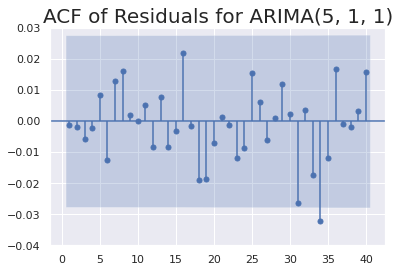

In [36]:
df['res_ar_5_i_1_ma_1'] = results_ar_5_i_1_ma_1.resid
sgt.plot_acf(df.res_ar_5_i_1_ma_1, zero = False, lags = 40)
plt.title("ACF of Residuals for ARIMA(5, 1, 1)", size = 20)
plt.ylim(-0.04, 0.03)
plt.show()

## Models with Higher Levels of Integration
* We only rely on integration, when our time-series doesn't come from a stationary process

In [37]:
df["delta_prices"] = df.market_value.diff(1)

In [38]:
model_delta_ar_1_i_1_ma_1 = ARIMA(df.delta_prices[1:], order = (1, 0, 1))
results_delta_ar_1_i_1_ma_1 = model_delta_ar_1_i_1_ma_1.fit()
print(results_delta_ar_1_i_1_ma_1.summary())

                               SARIMAX Results                                
Dep. Variable:           delta_prices   No. Observations:                 5020
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -27603.666
Date:                Tue, 28 Mar 2023   AIC                          55215.333
Time:                        23:30:10   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5639      0.753      0.749      0.454      -0.911       2.039
ar.L1          0.7476      0.059     12.673      0.000       0.632       0.863
ma.L1         -0.7937      0.053    -14.871      0.0

In [39]:
sts.adfuller(df.delta_prices[1:])

(-32.244093495707475,
 0.0,
 5,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54845.96104221891)

In [40]:
model_ar_1_i_2_ma_1 = ARIMA(df.market_value, order = (1, 2, 1))
results_ar_1_i_2_ma_1 = model_ar_1_i_2_ma_1.fit()
print(results_ar_1_i_2_ma_1.summary())

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 2, 1)   Log Likelihood              -27614.177
Date:                Tue, 28 Mar 2023   AIC                          55234.353
Time:                        23:52:29   BIC                          55253.916
Sample:                    01-07-1994   HQIC                         55241.209
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0178      0.010     -1.808      0.071      -0.037       0.001
ma.L1         -1.0000      0.011    -90.493      0.000      -1.022      -0.978
sigma2      3513.2522     54.679     64.253      0.0

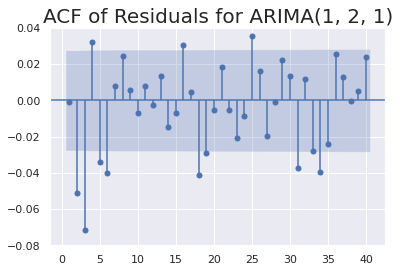

In [49]:
df['res_ar_1_i_2_ma_1'] = results_ar_1_i_2_ma_1.resid
sgt.plot_acf(df.res_ar_1_i_2_ma_1[2:], zero = False, lags = 40)
plt.title("ACF of Residuals for ARIMA(1, 2, 1)", size = 20)
plt.ylim(-0.08, 0.04)
plt.show()

### Issues
- Transform the data several times
- Differentiate the values from $0$
- Failing to converge
- Numerical instability
- The more layers we add, the harder it is to interpret the results


## ARIMAX
A model that takes into account more than just prices or past residuals
- $MAX$ models
- $ARMAX$ Non-integrated
- $ARIMAX$ Integrated

$$ΔP_t=c+βX+\sum_{i=1}^{p}ϕ_iΔP_{t-i}+\sum_{i=1}^{q}θ_iΔϵ_{t-i}+ϵ_t$$
- $β$ : A value which will be fitted based on the model selection and the data
- $X$ : can be any variable we are interested in (like categorical variable separating the different days of the week, combinations of several different external factors, any other variable or variables that can affect prices). They are called *exogeneous* variables.
* We can use S&P 500 prices as exogeneous variable.

In [57]:
model_ar_1_i_1_ma_1_Xspx = ARIMA(df.market_value, exog = df.spx, order = (1, 1, 1))
results_ar_1_i_1_ma_1_Xspx = model_ar_1_i_1_ma_1_Xspx.fit()
print(results_ar_1_i_1_ma_1_Xspx.summary())

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -26693.392
Date:                Wed, 29 Mar 2023   AIC                          53394.784
Time:                        00:12:32   BIC                          53420.869
Sample:                    01-07-1994   HQIC                         53403.925
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.6928      0.035     76.407      0.000       2.624       2.762
ar.L1          0.2571      0.029      8.812      0.000       0.200       0.314
ma.L1         -0.5460      0.025    -21.791      0.0

## SARIMAX

* All the models that we have seen so far (ARMA, ARIMA, ARIMAX) work with the data with same seasonality. To hanle the seasonality, we use *SARMA*, *SARIMA* or *SARIMAX*.
* **SARIMAX** requires 4 additional orders.
$$ (p, d, q)(P, D, Q, s) $$
- $(P, D, Q)$ : seasonal variations of the ARIMA orders. In other words, we have a seasonal autoregressive order $P$, seasonal moving average order $Q$ and seasonal integration $D$.
- $s$ : Length of cycle. The number of periods needed to pass before the tendency reappears. For example, if we have hourly data and a cycle length is $24$, then the seasonal pattern appears once every $24$ hours. If $s=1$, then every period is its own cycle cycle, so we assume no seasonality, and the pattern is just autocorrelation.
- If we want to inspect a seasonal trend, we need to make sure to set the appropriate cycle length.

---

***Example*** :

Let's say we have the model bellow :
$$SARIMAX(1, 0, 2)(2, 0, 1, 5)$$

We are simply including the values from five and ten periods ago, similarly we add the erro term from five periods ago.
 $$y_t=c+\sum_{i=1}^{p}ϕ_iy_{t-i}+\sum_{i=1}^{q}\theta_i\epsilon_{t-i}+\sum_{i=1}^{P}\Phi_i\sum_{j=0}^{p}ϕ_jy_{t-si-j}+\sum_{i=1}^{Q}\Theta_i\sum_{j=0}^{q}\theta_j\epsilon_{t-si-j}+\epsilon_t\\θ_0=1\\ϕ_0=1$$

In [60]:
model_sarimax = SARIMAX(df.market_value, exog = df.spx, order = (1, 0, 1), seasonal_order=(2, 0, 1, 5))
results_sarimax = model_sarimax.fit()
print(results_sarimax.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      market_value   No. Observations:                 5021
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood              -26712.780
Date:                           Wed, 29 Mar 2023   AIC                          53439.560
Time:                                   01:16:26   BIC                          53485.210
Sample:                               01-07-1994   HQIC                         53455.556
                                    - 04-05-2013                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.7037      0.035     76.430      0.000       2.634       2.773
ar.L1          0.9998      0.001   1913.710

## Volatility

The magnitude of $\epsilon_t$
$$Volatility≈Variance$$
- Low variance $\implies$ Stability $\implies$ Low risk $\implies$ Safety
- To solve the positive-negative conundrum, we square the values.
- Squaring the values penalizes high differences between true values and predictions more.
- Squaring the values increases the importance of big unpredicted shocks.